# Detect Christmas trees with CLIP

**Idea**: show only the top image that has a similarity score with the embedding of the sentence _"A plot of a Christmas tree shape"_

Is it an overkill? Maybe.

---

For those who don't know about CLIP:
it is a model made by OpenAI and CLIP stands for _Contrastive Language-Image Pre-Training_.

Its goal is to find a common embedding space between sentences and images.

In [ ]:
#@title Imports from utils
class Robot:
    def __init__(self, pos_x: int, pos_y: int, vel_x: int, vel_y: int):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.vel_x = vel_x
        self.vel_y = vel_y

    def step(self, rows: int, cols: int, steps: int = 1):
        self.pos_x = (self.pos_x + self.vel_x * steps) % cols
        self.pos_y = (self.pos_y + self.vel_y * steps) % rows

    def copy(self) -> 'Robot':
        return Robot(self.pos_x, self.pos_y, self.vel_x, self.vel_y)


def read_input(filename: str = 'aoc_14.txt') -> list[Robot]:
    robots: list[Robot] = []

    with open(filename) as f:
        for line in f:
            # p=0,4 v=3,-3
            line = line.strip()

            # p=0,4
            # v=3,-3
            pos_xy, vel_xy = line.split(' ')

            pos_x, pos_y = map(int, pos_xy[2:].split(','))
            vel_x, vel_y = map(int, vel_xy[2:].split(','))

            robots.append(Robot(pos_x, pos_y, vel_x, vel_y))

    return robots


def step_robots(robots: list[Robot], rows: int, cols: int, steps: int = 1):
    for robot in robots:
        robot.step(rows, cols, steps)


# Show an example plot of robots at second 0

In [ ]:
robots = read_input()

In [ ]:
from PIL import Image
import numpy as np

def create_image(robots: list[Robot], rows: int = 103, cols: int = 101) -> np.array:
  image = np.full(shape=(rows, cols, 3), fill_value=0, dtype=np.uint8)

  for robot in robots:
    x, y = robot.pos_x, robot.pos_y
    image[y, x] = (0, 255, 0)  # Green

  return image

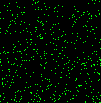

In [ ]:
Image.fromarray(create_image(robots))

# Do the detection

In [ ]:
#@title Create dataset
from torch.utils.data import Dataset

class ChristmasTreeDataset(Dataset):
  def __init__(self, robots: list[Robot], rows: int, cols: int):
    self.robots = robots
    self.rows = rows
    self.cols = cols

  def __len__(self) -> int:
    return self.rows * self.cols + 1

  def __getitem__(self, after_seconds: int) -> tuple[np.array, int]:
    # Deep copy the robots list
    new_robots = [ robot.copy() for robot in robots ]

    # Go ahead of the required amount of steps
    for robot in new_robots:
      robot.step(self.rows, self.cols, steps=after_seconds)

    # Generate the plot image
    plot_image = create_image(new_robots, self.rows, self.cols)

    return plot_image, after_seconds

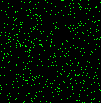

In [ ]:
trees_dataset = ChristmasTreeDataset(robots, rows=103, cols=101)

# Show an example
image, _ = trees_dataset[42]
Image.fromarray(image)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4096  #@param {type: 'integer'}

trees_dataloader = DataLoader(trees_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title Load CLIP model
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    device_map='cuda',
    torch_dtype=torch.float16,
    attn_implementation="sdpa",
)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
identification_text = "A plot of a Christmas tree shape"  #@param {type: 'string'}

@torch.no_grad()
def find_best_image(images: np.array, indexes: tuple[int]) -> tuple[int, float]:
  # Transform images from a batched np.array to a tuple of PIL.Image.Image
  images = tuple(Image.fromarray(image.cpu().numpy()) for image in images)

  # Preprocess text and image inputs
  inputs = processor(text=[identification_text], images=images, return_tensors='pt').to('cuda')

  # Run CLIP
  outputs = model(**inputs)
  logits = outputs.logits_per_image.view(-1)

  # Return the ID and the score of the most similar image
  logits_index = torch.argmax(logits)
  image_id = indexes[logits_index]
  image_score = logits[logits_index]

  return image_id.item(), image_score.item()

In [ ]:
from tqdm import tqdm

top_image_id, top_image_score = 0, 0

for images, indexes in tqdm(trees_dataloader):
  image_id, image_score = find_best_image(images, indexes)

  if image_score > top_image_score:
    top_image_id = image_id
    top_image_score = image_score

100%|██████████| 3/3 [00:52<00:00, 17.38s/it]


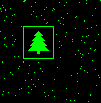

In [ ]:
#@title Show top image found
image, _ = trees_dataset[top_image_id]
Image.fromarray(image)

In [ ]:
top_image_id

7892